In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
K = 10
TRIALS = 1000
ITERATIONS = 2000
MEAN_MEAN = 0
MEAN_STDDEV = 1
SAMPLE_STDDEV = 1
MEANS = np.random.normal(MEAN_MEAN, MEAN_STDDEV, K)
DATA = np.array([np.random.normal(mu, SAMPLE_STDDEV, (TRIALS, ITERATIONS)) for mu in MEANS])
EPSILON = 0.1

In [3]:
print(DATA.shape)
print(MEANS)
print(np.mean(DATA, axis=1))

(10, 1000, 2000)
[-0.22794622  0.52349812  0.22253302  2.02362227 -0.25560462  1.56929376
  0.71701168 -1.05989081  0.06489006 -0.0209701 ]
[[-0.25280782 -0.22828449 -0.23322541 ... -0.21692677 -0.19493582
  -0.25412302]
 [ 0.50993216  0.52776971  0.55737832 ...  0.52128903  0.49971412
   0.50825751]
 [ 0.19222084  0.18925006  0.28428437 ...  0.15233672  0.26603522
   0.16829856]
 ...
 [-1.0904907  -0.99158756 -1.08705058 ... -1.11718292 -1.053171
  -1.00642213]
 [ 0.00355688  0.07205809  0.10418273 ...  0.05490196  0.06477223
   0.05594464]
 [ 0.01023782 -0.00190317 -0.01923545 ...  0.00268205 -0.01990245
  -0.02532969]]


In [5]:
class Env:
    def __init__(self, data, true_means):
        self.data = data
        self.true_means = true_means

class Bandit:
    def __init__(self, k, env, epsilon=None, ucb=None, gradient=None, q_0=0, step=0, iter=0):
        self.k = k
        self.env = env
        self.epsilon = epsilon
        self.ucb = ucb
        self.gradient = gradient
        self.steps = self.env.data.shape[1]
        self.iters = self.env.data.shape[2]
        self.counts = np.zeros(k)
        self.q_0 = q_0
        self.q = np.full(self.k, self.q_0, dtype=float)
        self.avg = np.zeros(self.steps, dtype=float)
        self.opt = np.zeros(self.steps, dtype=float)
        self.step = step
        self.iter = iter

    def select(self):
        if self.epsilon is not None:
            x = np.random.random()
            if x > self.epsilon:
                return np.argmax(self.q)
            else:
                return np.random.randint(0, self.k)

        if self.ucb:
            return np.argmax(self.q + self.ucb*np.sqrt(np.log(1 + self.step) / (self.counts + 1e-5)))
        
        if self.gradient:
            p = np.exp(self.q)/np.sum(np.exp(self.q))
            x = np.random.choice(np.arange(self.k), p=p)
            return x

    def act(self):
        index = self.select()
        reward = self.env.data[index, self.step, self.iter]
        n = self.counts[index]
        mean = self.q[index]
        if self.step == 0:
            self.avg[0] = reward
            self.opt[0] = int(index == np.argmax(self.env.true_means))
        else:
            self.avg[self.step] = (self.step * self.opt[self.step-1] + reward) / (self.step + 1)
            self.opt[self.step] = (self.step * self.opt[self.step-1] + int(index == np.argmax(self.env.true_means))) / (self.step + 1)
        
        if self.epsilon is not None or self.ucb:
            self.q[index] = (n * mean + reward) / (n+1)

        else: # gradient
            id = np.zeros(self.k)
            id[index] = 1
            self.q[index]
            self.q += self.gradient * (reward - self.avg[self.step]) * (id - np.exp(self.q)/np.sum(np.exp(self.q)))

        self.counts[index] += 1
        self.step += 1
        
    def reset(self):
        self.counts = np.zeros(self.k)
        self.q = np.full(self.k, self.q_0, dtype=float)
        self.avg = np.zeros(self.steps)
        self.opt = np.zeros(self.steps)
        self.step = 0
        self.iter += 1
        
    def run(self):
        avg = np.zeros((self.iters, self.steps))
        opt = np.zeros((self.iters, self.steps))
        for i in range(self.iters):
            for j in range(self.steps):
                self.act()
                avg[i, j] = self.avg[j]
                opt[i, j] = self.opt[j]
            self.reset()
        avg = np.mean(avg, axis=0)
        opt = np.mean(opt, axis=0)
        return avg, opt

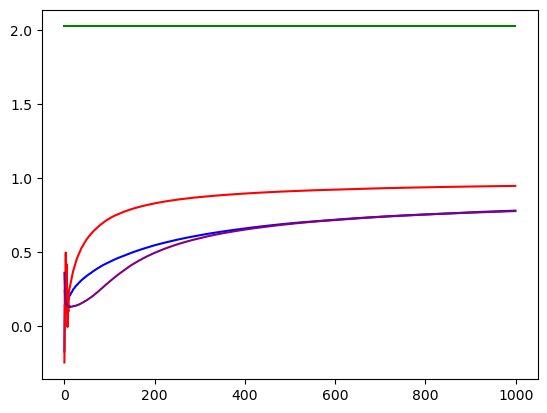

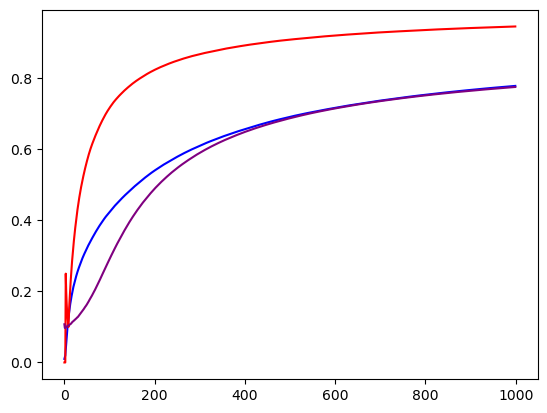

In [6]:
env = Env(DATA, MEANS)
bandit1 = Bandit(K, env, epsilon=EPSILON)
avg1, opt1 = bandit1.run()


bandit2 = Bandit(K, env, ucb=1)
avg2, opt2 = bandit2.run()

bandit3 = Bandit(K, env, gradient=0.1)
avg3, opt3 = bandit3.run()

plt.plot(avg1, color='blue')
plt.plot(avg2, color='red')
plt.plot(avg3, color='purple')
plt.plot(np.full(TRIALS, np.max(MEANS)), color='green')
plt.show()

plt.plot(opt1, color='blue')
plt.plot(opt2, color='red')
plt.plot(opt3, color='purple')
plt.show()